In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
detectors_run4 = pd.read_excel("cms_system_140.xlsx", sheet_name="Detectors")
triggers_run4 = pd.read_excel("cms_system_140.xlsx", sheet_name="Triggers")

In [ ]:
detectors_run4

,Category,Detector,Data (bytes),Sample Rate,True Pass,True Discard,False Pass (alpha),False Discard (beta),Compression,PU 140
0,Tracking,Inner Tracker,1010000,40000000,1,0,0,0,0,1.010
1,Tracking,Outer Tracker PS,500000,40000000,1,0,0,0,0,0.500
2,Tracking,Outer Tracker 2S,300000,40000000,1,0,0,0,0,0.300
3,Tracking,Track Finder TPG,10000,40000000,1,0,0,0,0,0.010
4,Timing,MIP Timing BTL,170000,40000000,1,0,0,0,0,0.170
5,Timing,MIP Timing ETL,310000,40000000,1,0,0,0,0,0.310
6,Calorimetry,ECAL Barrel,420000,40000000,1,0,0,0,0,0.420
7,Calorimetry,HCAL Barrel,240000,40000000,1,0,0,0,0,0.240
8,Calorimetry,HCAL HO,30000,40000000,1,0,0,0,0,0.030
9,Calorimetry,HCAL HF,60000,40000000,1,0,0,0,0,0.060


In [ ]:
triggers_run4

,Output,Name,Data (bytes),True Pass,True Discard,False Pass (alpha),False Discard (beta),Compression,PU 140,PU 200
0,Intermediate,Tracking,0,1,0,0,0,0,NaN,NaN
1,Intermediate,Timing,0,1,0,0,0,0,NaN,NaN
2,Intermediate,Calorimetry,0,1,0,0,0,0,NaN,NaN
3,Intermediate,Muon,0,1,0,0,0,0,NaN,NaN
4,Global,Intermediate,260000,1,399,0,0,0,0.26,0.26
5,Disk,Global,0,1,19,0,0,0,NaN,NaN
6,NaN,Disk,0,1,0,0,0,0,NaN,NaN


In [ ]:
def entry_to_confusion(entry: pd.core.series.Series):
    tp = entry["True Pass"]
    td = entry["True Discard"]
    fp = entry["False Pass (alpha)"]
    fd = entry["False Discard (beta)"]

    confusion = np.array([[td, fd], [fp, tp]])
    return confusion

In [ ]:
def detectors(detector_data: pd.DataFrame):
    n = len(detector_data)
    nodes = []
    edges = []

    for i in range(n):
        detector = detector_data.iloc[i]
        name = detector["Detector"]
        system = detector["Category"]
        properties = {
                      "sample data": detector["Data (bytes)"],
                      "sample rate": detector["Sample Rate"],
                      "error matrix": entry_to_confusion(detector),
                      "reduction": 1.0 - detector["Compression"],
                      "complexity": lambda x: x,
                      }
        nodes.append((name, properties))
        edges.append((name, system))

    return nodes, edges

In [ ]:
def triggers(trigger_data: pd.DataFrame):
    n = len(trigger_data)
    edges = []
    triggers = []

    for i in range(n):
        trigger = trigger_data.iloc[i]
        name = trigger["Name"]
        properties = {
            "error matrix": entry_to_confusion(trigger),
            "reduction": 1.0 - trigger["Compression"],
            "sample data": trigger["Data (bytes)"],
        }
        triggers.append((name, properties))

        output = trigger["Output"]
        if not pd.isna(output):
            edge = (trigger["Name"], trigger["Output"])
            edges.append(edge)

    return triggers, edges

In [ ]:
def identify_root(graph: nx.classes.digraph):
    od = list(graph.out_degree)
    roots = list(filter(lambda x: x[1] == 0, od))
    assert len(roots) == 1, "More than 1 root identified"
    return roots[0]


In [ ]:
def construct_graph(detector_data: pd.DataFrame, trigger_data: pd.DataFrame):
    g = nx.DiGraph()
    #add the nodes for detectors
    detector_nodes, detector_edges = detectors(detector_data)
    g.add_nodes_from(detector_nodes)
    #add the nodes for trigger systems
    trigger_nodes, trigger_edges = triggers(trigger_data)
    g.add_nodes_from(trigger_nodes)
    #connect the systems
    g.add_edges_from(detector_edges)
    g.add_edges_from(trigger_edges)
    #identify the final (root) node
    root = identify_root(g)
    g.graph["Root Node"] = root[0]
    return g

    globals = measure(g)
    for k, v in globals:
        g[k] = v

    return g, globals


In [ ]:
cms_pu140 = construct_graph(detectors_run4, triggers_run4)

In [ ]:
cms_pu140.edges

OutEdgeView([('Inner Tracker', 'Tracking'), ('Outer Tracker PS', 'Tracking'), ('Outer Tracker 2S', 'Tracking'), ('Track Finder TPG', 'Tracking'), ('MIP Timing BTL', 'Timing'), ('MIP Timing ETL', 'Timing'), ('ECAL Barrel', 'Calorimetry'), ('HCAL Barrel', 'Calorimetry'), ('HCAL HO', 'Calorimetry'), ('HCAL HF', 'Calorimetry'), ('HGCAL', 'Calorimetry'), ('HGCAL TPG Stage1', 'Calorimetry'), ('HGCAL TPG Stage2', 'Calorimetry'), ('Muon DT', 'Muon'), ('Muon CSC', 'Muon'), ('Muon GEM GE1', 'Muon'), ('Muon GEM GE2', 'Muon'), ('Muon GEM ME0', 'Muon'), ('Muon RPC', 'Muon'), ('Tracking', 'Intermediate'), ('Timing', 'Intermediate'), ('Calorimetry', 'Intermediate'), ('Muon', 'Intermediate'), ('Intermediate', 'Global'), ('Global', 'Disk')])

In [ ]:
cms_pu140.edges[("Inner Tracker", "Tracking")]

{}

In [ ]:
list(cms_pu140.nodes)

['Inner Tracker',
 'Outer Tracker PS',
 'Outer Tracker 2S',
 'Track Finder TPG',
 'MIP Timing BTL',
 'MIP Timing ETL',
 'ECAL Barrel',
 'HCAL Barrel',
 'HCAL HO',
 'HCAL HF',
 'HGCAL',
 'HGCAL TPG Stage1',
 'HGCAL TPG Stage2',
 'Muon DT',
 'Muon CSC',
 'Muon GEM GE1',
 'Muon GEM GE2',
 'Muon GEM ME0',
 'Muon RPC',
 'Tracking',
 'Timing',
 'Calorimetry',
 'Muon',
 'Intermediate',
 'Global',
 'Disk']

In [ ]:
cms_pu140.graph["Root Node"]

'Disk'

In [ ]:
cms_pu140.nodes["Inner Tracker"]

{'sample data': 1010000,
 'sample rate': 40000000,
 'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'complexity': <function __main__.detectors.<locals>.<lambda>(x)>}

In [ ]:
cms_pu140.edges[("Inner Tracker", "Tracking")]

{}

In [ ]:
cms_pu140.nodes["Tracking"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0}

In [ ]:
cms_pu140.edges[("Tracking", "Intermediate")]

{}

In [ ]:
cms_pu140.nodes["Disk"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0}

In [ ]:
def message_size(graph: nx.classes.digraph, node: str):
    """
    Return the total size of a message processed by a node
    """
    inputs = list(graph.predecessors(node))
    input_data = sum([message_size(graph, n) for n in inputs])
    this_node = graph.nodes[node]
    if "sample data" in this_node:
        total = input_data + this_node["sample data"]
    else:
        total = input_data

    total = total * this_node["reduction"]
    this_node["message size"] = total
    return total


In [ ]:
def classifier_rate(error_matrix: np.ndarray):
        """
        Return the negative / positive classification rate from an error matrix
        """
        rates = np.einsum("ab,a -> a", error_matrix, np.array([1, 1]))
        return rates / rates.sum()

In [ ]:
classifier_rate(cms_pu140.nodes["Intermediate"]["error matrix"]) * 40e6

array([39900000.,   100000.])

In [ ]:
def message_rate(graph: nx.classes.digraph, node: str):
    """
    Return the rate of messages produced by a node
    """
    this_node = graph.nodes[node]
    if "sample rate" in this_node:
        #get the sampling rate of a detector
        input_rate = this_node["sample rate"]
    else:
        #or take the maximum rate of the inputs
        inputs = list(graph.predecessors(node))
        assert len(inputs) > 0, "Missing sample rate from detector or isolated node"
        input_rate = max([message_rate(graph, n) for n in inputs])
    
    output_rate = classifier_rate(this_node["error matrix"])[1] * input_rate
    this_node["message rate"] = output_rate
    return output_rate 

In [ ]:
g1 = cms_pu140.copy()

In [ ]:
g2 = message_size(g1, "Disk")

In [ ]:
g3 = message_rate(g1, "Disk")

In [ ]:
g1.nodes["Tracking"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0,
 'message size': 1820000.0,
 'message rate': 40000000.0}

In [ ]:
"message rate" in g1.nodes["Tracking"]

True

In [ ]:
for node in g1.nodes:
    if not "message rate" in g1.nodes[node]:
        print(node)

In [ ]:
for node in g1.nodes:
    if not "message rate" in g1.nodes[node]:
        print(node)

In [ ]:
link_throughput(g1)

In [ ]:
g1.edges[("Intermediate", "Global")]

{'throughput': 609300000000.0}

In [ ]:
g1.edges[("Global", "Disk")]

{'throughput': 30465000000.0}

In [ ]:
def link_throughput(graph: nx.classes.digraph):
    def calc_throughput(edge):
        input_node = graph.nodes[edge[0]]
        throughput = input_node["message size"] * input_node["message rate"]
        graph.edges[edge]["throughput"] = throughput

    list(map(calc_throughput, graph.edges))

In [ ]:
g1.edges[("Intermediate", "Global")]

{}

In [ ]:
def update_throughput(graph: nx.classes.digraph):
    graph = graph.copy()
    #call the recursive update function on the root node
    root = graph.graph["Root Node"]
    message_size(graph, root)
    message_rate(graph, root)
    link_throughput(graph)
    
    return graph
    

In [ ]:
message_rate(g1, "Disk")

5000.0

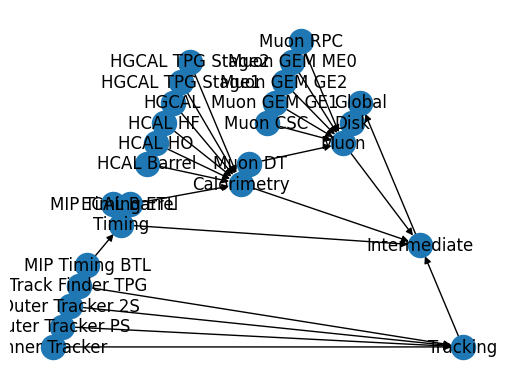

In [ ]:
subax1 = plt.subplot(111)
nx.draw_planar(cms_pu140, with_labels=True)